/tmp/ipykernel_1749/95964446.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customers_per_interval = data_filtered.groupby('entry_interval')['group_size'].sum().reset_index()


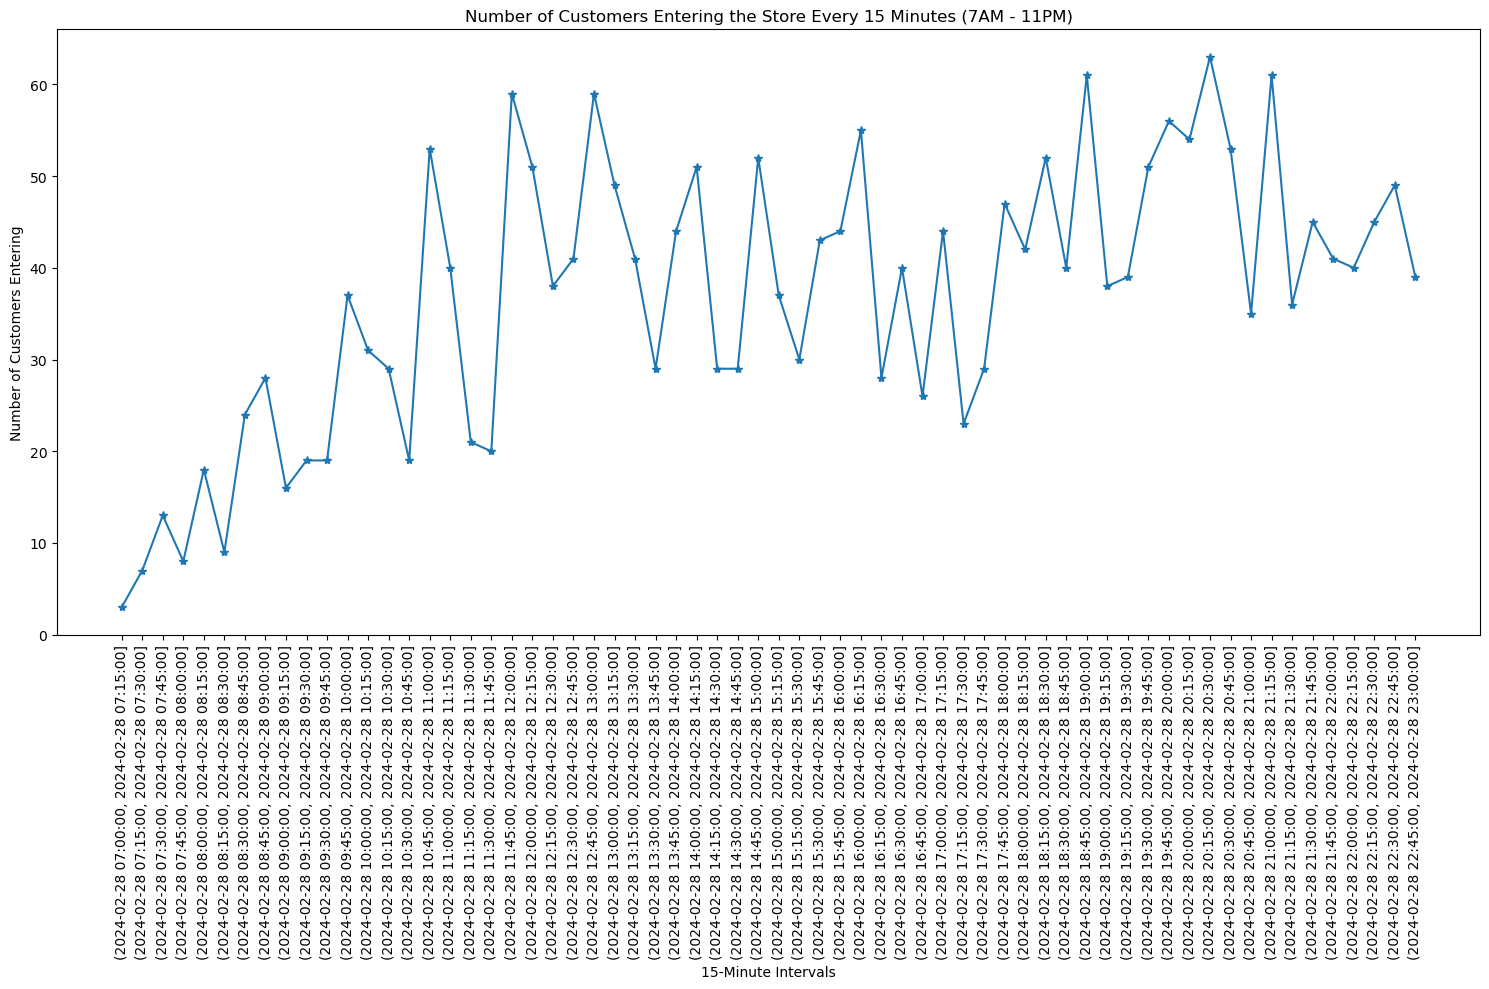

Average customers per hour: 148.25
Average flow time (minutes): 2.1050608347386173


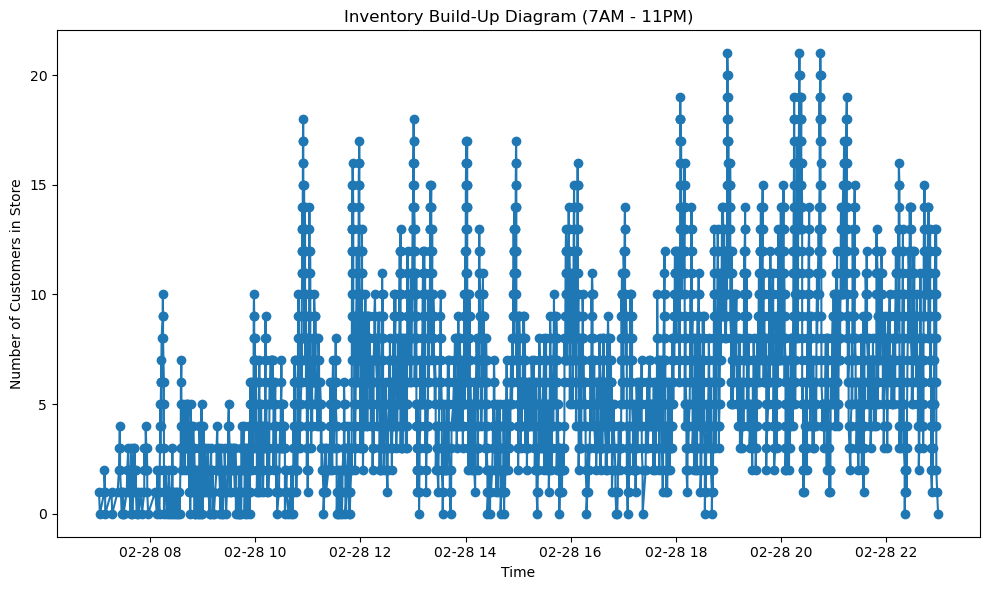

Total time (area under curve): 4329.789599999684
Average inventory: 0       0.0000
1      -1.0666
2       0.0000
3       0.1000
4       0.0000
         ...  
4359    0.0000
4360    0.0000
4361    0.0000
4362    0.0000
4363   -1.0000
Name: weighted_inventory, Length: 4364, dtype: float64
Average arrival rate (customers per minute): 2.470833333333333
Calculated inventory using Little's Law: 5.201254479166667
Actual average inventory: 0       0.0000
1      -1.0666
2       0.0000
3       0.1000
4       0.0000
         ...  
4359    0.0000
4360    0.0000
4361    0.0000
4362    0.0000
4363   -1.0000
Name: weighted_inventory, Length: 4364, dtype: float64


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("/home/jovyan/Rogers_022824.csv")
# Remove duplicate rows from the DataFrame
data = data.drop_duplicates(subset=['session_id'])
# Convert 'purchase_datetime' to datetime
data['purchase_datetime'] = pd.to_datetime(data['purchase_datetime'])
#print(data['purchase_datetime'])
#print(pd.to_timedelta(data['trip_duration_mins'], unit='m'))
# Calculate entry time (purchase_datetime - trip_duration_mins)
data['entry_datetime'] = data['purchase_datetime'] - pd.to_timedelta(data['trip_duration_mins'], unit='m')

# Define start and end times
start_day = pd.Timestamp('2024-02-28 07:00:00')
end_day = pd.Timestamp('2024-02-28 23:00:00')

# Filter data for the given time range
data_filtered = data[(data['entry_datetime'] >= start_day) & (data['entry_datetime'] <= end_day)]

# Group customers into 15-minute intervals
data_filtered['entry_interval'] = pd.cut(data_filtered['entry_datetime'], bins=pd.date_range(start=start_day, end=end_day, freq='15min'))

# Sum group sizes in each 15-minute interval
customers_per_interval = data_filtered.groupby('entry_interval')['group_size'].sum().reset_index()

# Plot the number of customers entering every 15 minutes
plt.figure(figsize=(15, 10))
plt.plot(customers_per_interval['entry_interval'].astype(str), customers_per_interval['group_size'], marker='*')
plt.xticks(rotation=90)
plt.xlabel('15-Minute Intervals')
plt.ylabel('Number of Customers Entering')
plt.title('Number of Customers Entering the Store Every 15 Minutes (7AM - 11PM)')
plt.tight_layout()
plt.show()

# Calculate the average number of customers entering per hour
customers_per_hour = customers_per_interval.groupby(customers_per_interval['entry_interval'].apply(lambda x: x.left.hour))['group_size'].sum()
average_customers_per_hour = customers_per_hour.mean()
print(f"Average customers per hour: {average_customers_per_hour}")

# Calculate the average flow time
data_filtered['total_duration_per_group'] = data_filtered['trip_duration_mins'] * data_filtered['group_size']
total_group_size = data_filtered['group_size'].sum()
average_flow_time = data_filtered['total_duration_per_group'].sum() / total_group_size
print(f"Average flow time (minutes): {average_flow_time}")

# Create inventory build-up timeline
timeline = pd.DataFrame({
    'datetime': pd.concat([data_filtered['entry_datetime'], data_filtered['purchase_datetime']]),
    'change': pd.concat([data_filtered['group_size'], -data_filtered['group_size']])
}).sort_values(by='datetime').reset_index(drop=True)

# Calculate cumulative inventory inside the store
timeline['inventory'] = timeline['change'].cumsum()

# Plot the inventory build-up diagram
plt.figure(figsize=(10, 6))
plt.plot(timeline['datetime'], timeline['inventory'], marker='o')
plt.xlabel('Time')
plt.ylabel('Number of Customers in Store')
plt.title('Inventory Build-Up Diagram (7AM - 11PM)')
plt.tight_layout()
plt.show()

# Calculate total time and average inventory
timeline['calculated_inventory'] = 0  # Initialize new column for calculated inventory

# Loop through the rows of the timeline and calculate inventory step by step
for i in range(1, len(timeline)):
    # Previous inventory + people who entered - people who left
    timeline.loc[i, 'calculated_inventory'] = timeline.loc[i-1, 'calculated_inventory'] + timeline.loc[i, 'change']

# Now 'calculated_inventory' will reflect the number of people inside the store at each point
timeline['time_diff'] = timeline['datetime'].diff().dt.total_seconds().fillna(0) / 60  # Time difference in minutes

# Now calculate the area under the curve using the 'calculated_inventory'
timeline['weighted_inventory'] = timeline['calculated_inventory'] * timeline['time_diff']

# You can now sum the 'weighted_inventory' to get the total time summed up over all customers
total_time = timeline['weighted_inventory'].sum()
average_inventory= timeline['weighted_inventory']

print(f"Total time (area under curve): {total_time}")
print(f"Average inventory: {average_inventory}")

# Verify Little's Law: L = lambda * W
total_customers = total_group_size
average_arrival_rate = total_customers / total_observation_time
calculated_inventory = average_arrival_rate * average_flow_time

print(f"Average arrival rate (customers per minute): {average_arrival_rate}")
print(f"Calculated inventory using Little's Law: {calculated_inventory}")
print(f"Actual average inventory: {average_inventory}")